# Capítulo 14: Forward-Backward Sweep Adaptado 

### Exemplos numéricos do capítulo 

Para ilustrar o método, vamos propor exemplos e seus códigos aqui descritos. 

### Importando Bibliotecas

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from scipy.optimize import root_scalar

## Um estado com pontos finais fixos

Considere o seguinte exemplo:

\begin{align*}
    &\min_u \frac{1}{2}\int_0^1 x_1(t)^2 + u(t)^2 dt \\ 
    \text{sujeito a }&x_1 '(t) = x_2(t), x_1(0) = 1, \\
    &x_2 '(t) = -ru(t), x_2(0) = 0, x_2(1) = s, \\ 
    &r > 0, s < 0
\end{align*}

### Passo 1: Escrever condições necessárias 

Vejamos que o Hamiltoniano é 

$$
H = \frac{1}{2}(x_1^2 + u^2) + \lambda_1x_2 - r\lambda_2 u
$$

Assim, as equações adjuntas são
$$
\lambda_1 ' = -H_{x_1}  = -x_1 
$$
$$
\lambda_2 ' = -H_{x_2}  = - \lambda_1
$$
com condição de transversalidade $\lambda_1(1) = 0$. A condição de otimalidade é dada por 

$$
0 = H_u = u - r\lambda_2 \implies u^* = r \lambda_2
$$

In [2]:
diff_state = lambda t, x, u, r: np.array([
    x[1], 
    -r*u
])

diff_adjoint = lambda t, x, u, lambda_, r: np.array([
    -x[0], 
    -lambda_[0]
])

update_u = lambda t, x, lambda_, r: r*lambda_[:,1]

### Passo 2: Algoritmo de integração 

Aqui desenvolvemos os algoritmos de forward e de backward para a integração segundo o método de Runge-Kutta. 

In [3]:
def forward(g, t, x, u, r, h): 

    for i in range(len(t)-1):
        k1 = g(t[i],x[i],u[i], r)
        k2 = g(t[i]+h/2,x[i] + 0.5*h*k1, 0.5*(u[i] + u[i+1]), r)
        k3 = g(t[i]+h/2,x[i] + 0.5*h*k2, 0.5*(u[i] + u[i+1]), r)
        k4 = g(t[i]+h,x[i] + h*k3, u[i+1], r)
        x[i+1] = x[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return x 

def backward(dadj, t, x, u, lambda_, r, h): 

    for i in range(len(t)-1,0,-1):
        k1 = dadj(t[i],x[i],u[i],lambda_[i], r)
        k2 = dadj(t[i]-h/2,0.5*(x[i] + x[i-1]), 0.5*(u[i] + u[i-1]),lambda_[i] - 0.5*h*k1, r)
        k3 = dadj(t[i]-h/2,0.5*(x[i] + x[i-1]), 0.5*(u[i] + u[i-1]),lambda_[i] - 0.5*h*k2, r)
        k4 = dadj(t[i]-h,x[i-1], u[i-1], lambda_[i] - h*k3, r)
        lambda_[i-1] = lambda_[i] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return lambda_

### Passo 3: Método completo de controle ótimo

O código a seguir constrói o método forward-backward a partir de um chute $\theta$. Com esse valor, faremos $\lambda_2(t_1) = \theta$. A partir desse cálculo, obteremos um valor do aproximado do estado final $x_2(1)$, supondo que a convergência ocorra. O valor `h` é o passo do método de Runge-Kutta e `tol` é a tolerância do erro para o algoritmo. Eles estão pré-determinados nesse caso. 

In [4]:
def optimal_control(theta, r, h = 0.001, tol = 0.0001): 

    condition = -1 

    N = int(np.round(1/h)) 
    t = np.linspace(0,1,N+1)
    u = np.random.normal(scale=0.01, size=N+1)
    x = np.zeros(shape = (N+1, 2))
    lambda_ = np.zeros(shape = (N+1, 2))

    x[0] = np.array([1,0])
    lambda_[-1] = np.array([0,theta])

    while condition < 0: 

        u_old = u.copy()
        x_old = x.copy()
        lambda_old = lambda_.copy()

        x = forward(diff_state, t, x, u, r, h)
        lambda_ = backward(diff_adjoint, t, x, u, lambda_, r, h)

        
        u = 0.5*(update_u(t, x, lambda_, r) + u)

        cond1 = tol*np.sum(abs(u)) - np.sum(abs(u_old - u))
        cond2 = min(tol*np.sum(abs(x), axis=0) - np.sum(abs(x_old - x), axis=0))
        cond3 = min(tol*np.sum(abs(lambda_), axis=0) - np.sum(abs(lambda_old - lambda_), axis=0))
        condition = min(cond1, cond2, cond3) 

    return t,x,u,lambda_

### Passo 4: Método secante 

Por fim, precisamos encontrar o valor de $\theta$ correto. Para isso, vamos escrever a função $V(\theta) = \tilde{x}_{21} - s$, onde $\tilde{x}_{21}$ é uma aproximação para $x_{21}$ a partir de $\theta$. Queremos encontrar os zeros dessa função. Para isso usaremos o método descrito no capítulo e escrito na biblioteca `scipy`. 

In [5]:
V = lambda theta, r, s: optimal_control(theta, r)[1][-1][1] - s

theta = lambda r, s: root_scalar(f = V, 
                                 args = (r, s), 
                                 method = 'secant',
                                 x0 = -1, 
                                 x1 = 1,
                                 )

## Aplicando as funções ao exemplo 

Vamos fazer algumas exeperimentações. Por fim, vamos testar o código com valores de $r$ e $s$. 

In [6]:
r = 1 
s = -1 
t, x, u, lambda_ = optimal_control(theta(r, s).root, r)

Primeiro vamos verificar o valor $x_2(1)$. De fato não é o valor exato, mas é bem próximo do desejado. 

In [7]:
x[-1,1]

-1.0000000608421535

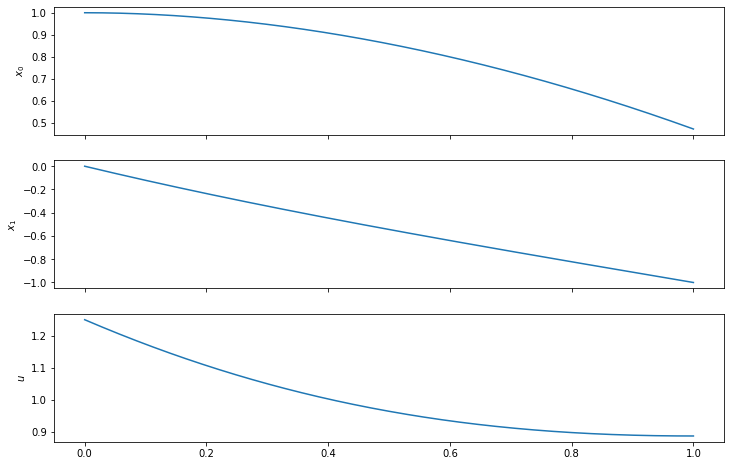

In [8]:
fig, ax = plt.subplots(3,1, sharex = True, figsize = (12, 8))

ax[0].plot(t, x[:,0])
ax[1].plot(t, x[:,1])
ax[2].plot(t, u)

ax[0].set_ylabel(r'$x_0$')
ax[1].set_ylabel(r'$x_1$')
ax[2].set_ylabel(r'$u$')

plt.show()

Variar o método para encontrar a raíz pode ser interessante. 

## Termos de payoff não lineares 

Considere o seguinte exemplo: 

\begin{align*}
    \min_u \frac{1}{4} x_2(1)^4 + &\frac{1}{2}\int_0^1 x_1(t)^2 + u(t)^2 dt \\
    \text{sujeito a }&x_1 '(t) = x_2(t), x_1(0) = 1, \\
    &x_2 '(t) = - ru(t), x_2(0) = 0, \\
    r > 0,
\end{align*}

Note que esse exemplo é muito próximo ao anterior, com diferença sendo: não fixamos $x_2(1)$, mas queremos minimizar uma função dele. Como $\phi(s) = \frac{1}{4}s^4, \phi '(s) = s^3$. Assim definimos
$$
V(\theta) = (\tilde{x}_{21})^3 - \theta
$$

O que precisamos mudar do código que já fizemos até então? Precisamos apenas mudar a função $V$! De resto, tudo será equivalente. 

In [9]:
V = lambda theta, r: (optimal_control(theta, r)[1][-1][1])**3 - theta

theta = lambda r: root_scalar(f = V, 
                              args = (r,), 
                              method = 'secant',
                              x0 = -1, 
                              x1 = 1,
                              )

## Aplicando as funções ao exemplo 

Vamos fazer algumas exeperimentações. Por fim, vamos testar o código com valores de $r$. 

In [10]:
r = 1 
t, x, u, lambda_ = optimal_control(theta(r).root, r)

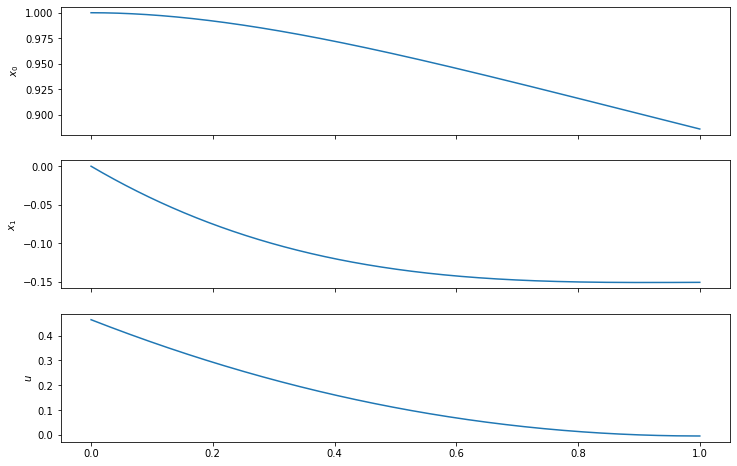

In [11]:
fig, ax = plt.subplots(3,1, sharex = True, figsize = (12, 8))

ax[0].plot(t, x[:,0])
ax[1].plot(t, x[:,1])
ax[2].plot(t, u)

ax[0].set_ylabel(r'$x_0$')
ax[1].set_ylabel(r'$x_1$')
ax[2].set_ylabel(r'$u$')

plt.show()

## Shots Múltiplos 

Considere o seguinte exemplo 

\begin{align}
    &\min_u \frac{1}{2}\int_0^1 x_1(t)^2 + u(t)^2 dt \\ 
    \text{sujeito a }&x_1'(t) = x_2(t), x_1(0) = 1, x_1(1) = 0, \\
    &x_2'(t) = -ru(t), x_2(0) = 0, x_2(1) = s, \\
    &r > 0, s < 0. 
\end{align}

Temos o mesmo exemplo, agora com $x_1$ com tempo final fixo. Nem $\lambda_1$, nem $\lambda_2$ tem valor conhecido em $1$ e, por isso, precisamos fazer chutes para ambos. Vamos fazer algumas mudanças para que tenhamos dois chutes. 

In [12]:
def optimal_control(theta1, theta2, r, h = 0.001, tol = 0.0001): 

    condition = -1 

    N = int(np.round(1/h)) 
    t = np.linspace(0,1,N+1)
    u = np.random.normal(scale=0.01, size=N+1)
    x = np.zeros(shape = (N+1, 2))
    lambda_ = np.zeros(shape = (N+1, 2))

    x[0] = np.array([1,0])
    lambda_[-1] = np.array([theta1, theta2])

    while condition < 0: 

        u_old = u.copy()
        x_old = x.copy()
        lambda_old = lambda_.copy()

        x = forward(diff_state, t, x, u, r, h)
        lambda_ = backward(diff_adjoint, t, x, u, lambda_, r, h)

        
        u = 0.5*(update_u(t, x, lambda_, r) + u)

        cond1 = tol*np.sum(abs(u)) - np.sum(abs(u_old - u))
        cond2 = min(tol*np.sum(abs(x), axis=0) - np.sum(abs(x_old - x), axis=0))
        cond3 = min(tol*np.sum(abs(lambda_), axis=0) - np.sum(abs(lambda_old - lambda_), axis=0))
        condition = min(cond1, cond2, cond3) 

    return t,x,u,lambda_

Vamos montar agora as duas funções para encontrar as raízes. 

In [13]:
# V1 = \tilde{x}_{11} - 0 
V1 = lambda theta1, r, s: optimal_control(theta1, f_theta2(theta1, r,s).root, r)[1][-1][0]
# V2 = \tilde{x}_{21} - s 
V2 = lambda theta2, theta1, r, s: optimal_control(theta1, theta2, r)[1][-1][1] - s

# encontra a raíz theta1. 
f_theta1 = lambda r, s: root_scalar(f = V1, 
                                     args = (r, s), 
                                     method = 'secant',
                                     x0 = -1, 
                                     x1 = 1,
                                     )
# encontra a raíz theta2, dado theta1 
f_theta2 = lambda theta1, r, s: root_scalar(f = V2, 
                                     args = (theta1, r, s), 
                                     method = 'secant',
                                     x0 = -1, 
                                     x1 = 1,
                                     )

## Aplicando as funções ao exemplo 

Vamos fazer algumas exeperimentações. Por fim, vamos testar o código com valores de $r$ e $s$. 

In [14]:
r = 1
s = -1

theta1 = f_theta1(r,s).root 
theta2 = f_theta2(theta1,r,s).root
t,x,u,_ = optimal_control(theta1, theta2, r)

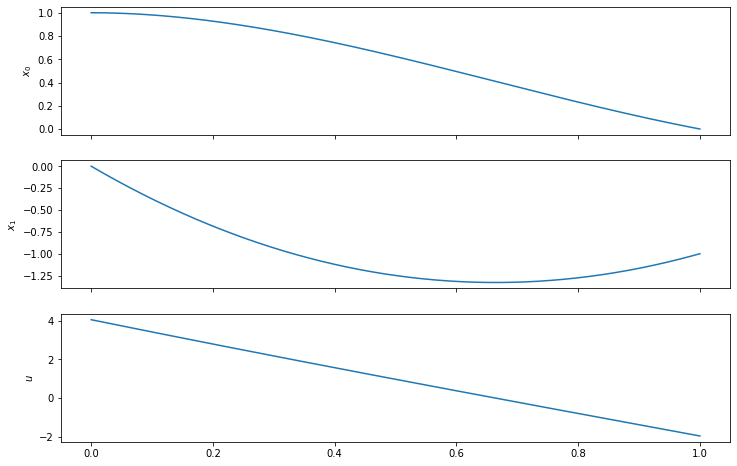

In [15]:
fig, ax = plt.subplots(3,1, sharex = True, figsize = (12, 8))

ax[0].plot(t, x[:,0])
ax[1].plot(t, x[:,1])
ax[2].plot(t, u)

ax[0].set_ylabel(r'$x_0$')
ax[1].set_ylabel(r'$x_1$')
ax[2].set_ylabel(r'$u$')

plt.show()

### Este é o fim do notebook